In [226]:
#export
from dataclasses import dataclass
from functools import reduce, partial
import torch
from torch import optim
from nbs.dl2.exp.nb_02 import getMnistData, assertNearZero
from nbs.dl2.exp.nb_03 import Dataset, createDataLoaders, accuracy
from nbs.dl2.exp.nb_04 import DataBunch
from nbs.dl2.exp.nb_05 import aggregateSchedulers, createCosineSchedulers, cosineScheduler
from nbs.dl2.exp.nb_06 import normalizeVectors, createBetterConvolutionModel
from nbs.dl2.exp.nb_07D import *

In [227]:
%matplotlib inline


In [228]:
xTraining, yTraining, xValidation, yValidation = getMnistData()
xTrainingNormalized, xValidationNormalized = \
    normalizeVectors(xTraining, xValidation)

In [229]:
assertNearZero(xTrainingNormalized.mean())
assertNearZero(xValidationNormalized.mean())
assertNearZero(1 - xTrainingNormalized.std())
assertNearZero(1 - xValidationNormalized.std())


In [230]:
layerSizes = [8, 16, 32, 64, 64]
numberOfClasses = 10
hiddenLayerSize = 75
batchSize = 64

In [231]:
trainingDataSet, validationDataSet = Dataset(xTrainingNormalized[:10000], yTraining[:10000]), Dataset(xValidationNormalized[:10000], yValidation[:10000])
trainingDataLoader, validationDataLoader = createDataLoaders(trainingDataSet, validationDataSet, batchSize)
imageDataBunch = DataBunch(trainingDataLoader, validationDataLoader, numberOfClasses)

In [232]:
class ProcessCancellationException(Exception): pass

In [233]:
def composeFunctions(funInput, functions): 
    return reduce(lambda accum, function: function(accum), 
                  functions, 
                  funInput)

In [234]:
result = composeFunctions(0, [
    lambda x: x + 1,
    lambda x: x + 2,
    lambda x: x + 3,
])

assert result == 6, "Composition is wrong"

In [235]:
@dataclass
class HyperParameters:
    learningRate: float = 1e-1
    weightDecay: float = 0.
    momentum: float = 0.9

In [236]:
#export
def flatMap(function, items):
    return reduce(lambda accum, manyItems: accum + manyItems,
           list(map(function, items)))

In [237]:
result = flatMap(lambda n: list(map(lambda _: n+1, range(n+1))), 
        list(range(3)))

assert result == [1, 2, 2, 3, 3, 3], "Flat map did not work"


In [238]:
class OptimizationFunction:
    
    def __call__(self, 
                 modelLayer, 
                 hyperParameters: HyperParameters):
        return hyperParameters
    
class LearningRateAnnealer(OptimizationFunction):
    def __init__(self, learningRateSupplier)-> None:
        self._learningRateSupplier = learningRateSupplier
        
    def __call__(self, modelLayer, hyperParameters: HyperParameters):
        hyperParameters.learningRate = self._learningRateSupplier()
        return super().__call__(modelLayer, hyperParameters)
    
class LearningRateOptimizer(OptimizationFunction):
    def __call__(self, 
                 modelLayer, 
                 hyperParameters: HyperParameters):
        modelLayer.data.add_(-hyperParameters.learningRate, modelLayer.grad.data)
        return super().__call__(modelLayer, hyperParameters)
    
class MomentumOptimizer(OptimizationFunction):
    
    def __init__(self)-> None:
        super().__init__()
        self._state = {}
        
    def __call__(self, 
                 modelLayer, 
                 hyperParameters: HyperParameters):
        if modelLayer not in self._state:
            self._state[modelLayer] = {
                'averageGradient': torch.zeros_like(modelLayer.grad.data)
            }
        modelLayerState = self._state[modelLayer]
        modelLayerState['averageGradient'].mul_(hyperParameters.momentum).add_((1 - hyperParameters.momentum) * modelLayer.grad.data)
        
        modelLayer.data.add_(-hyperParameters.learningRate, modelLayerState['averageGradient'])
        return super().__call__(modelLayer, hyperParameters)

** Weight Decay** is useful when you are having issues with over fitting the training data as the batches go on.
Added weight decay makes the parameter weights smaller so they learn less, but the can generalize better.

In [239]:
class WeightDecayOptimizer(OptimizationFunction):
    def __call__(self, 
                 modelLayer, 
                 hyperParameters: HyperParameters):
        modelLayer.data.mul_(1 - hyperParameters.learningRate * hyperParameters.weightDecay)
        return super().__call__(modelLayer, hyperParameters)

In [240]:
class Optimizer:
    def __init__(self, modelParameters, 
                 optimizationFunctions,
                 hyperParameters: HyperParameters=HyperParameters(learningRate=0.5)):
        super().__init__()
        self._modelParameters = list(modelParameters)
        self._hyperParameters = [hyperParameters for _ in self._modelParameters]
        self._optimizationFunctions = optimizationFunctions
        
    def getLayersWithGradients(self):
        return list(filter(lambda modelAndHyperParameters: modelAndHyperParameters[0].grad is not None, 
                           zip(self._modelParameters, self._hyperParameters)))
    
    def resetGradients(self):
        for modelParameter, _ in self.getLayersWithGradients():
            modelParameter.grad.detach_()
            modelParameter.grad.zero_()
    
    def optimizeModel(self):
        for modelParameter, hyperParameter in self.getLayersWithGradients():
            composeFunctions(hyperParameter, 
                             map(lambda fun: partial(fun, modelParameter), 
                                 self._optimizationFunctions))

In [241]:
convolutionalModelSR2 = createBetterConvolutionModel(numberOfClasses, layerSizes)

In [242]:
optimus = Optimizer(convolutionalModelSR2.parameters(), [])
len(optimus.getLayersWithGradients())

0

In [243]:
loss = torch.nn.functional.cross_entropy(convolutionalModelSR2(xTrainingNormalized), yTraining)
loss.backward()
len(optimus.getLayersWithGradients())

12

In [244]:
class LearningRateRecorder:
    def __init__(self, 
                 learningRateSupplier=lambda:0.5):
        super().__init__()
        self._aggregatedLearningRates = []
        self._learningRateSupplier = learningRateSupplier
    def __call__(self):
        learningRateReturned = self._learningRateSupplier()
        self._aggregatedLearningRates.append(learningRateReturned)
        return learningRateReturned
    
    def plotLearningRates(self):
        plotter.plot(self._aggregatedLearningRates)

## **Important Note**: PyTorch will NOT put the gradients on the parameters until backwards has been called on the model    

In [245]:
class TrainingSubscriber(StatisticsSubscriber, 
                         HookedSubscriber):

    def __init__(self,
                 lossFunction=torch.nn.functional.cross_entropy,
                 schedulingFunction=cosineScheduler(1e-1, 1e-6), 
                 optimizationFunctions=[]
                 ):
        super().__init__(name="Training")
        self._optimizer: Optimizer = None
        self._optimizationFunctions = optimizationFunctions
        self._schedulingFunction = schedulingFunction
        self._lossFunction = lossFunction
        
        self._learningRateRecorder = LearningRateRecorder()
        
        
        
    def plotLearningRate(self):
        self._learningRateRecorder.plotLearningRates()
        
    def getOptimizationFunctions(self):
        learningRateSupplier = lambda: self._schedulingFunction(self.calculateCurrentProgress())
        self._learningRateRecorder = LearningRateRecorder(learningRateSupplier )
        return [
            WeightDecayOptimizer(),
            LearningRateAnnealer(self._learningRateRecorder),
            MomentumOptimizer(),
            # LearningRateOptimizer()  
        ]

    def preModelTeach(self, model, epochs):
        super().preModelTeach(model, epochs)
        self._optimizer = Optimizer(model.parameters(), 
                                    self.getOptimizationFunctions(),
                                    HyperParameters(
                                        weightDecay=0.0,
                                        learningRate=self._schedulingFunction(0)
                                    ))
        self._totalEpochs = epochs

    def postBatchEvaluation(self, predictions, validationData):
        super().postBatchEvaluation(predictions, validationData)
        calculatedLoss = self._lossFunction(predictions, validationData)
        self._teachModel(calculatedLoss)
        self.postBatchLossConsumption(calculatedLoss)

    def _teachModel(self, loss):
        loss.backward() # adds auto gradients to model parameters
        self._optimizer.optimizeModel()
        self._optimizer.resetGradients() 

In [246]:
class TeacherOptimized:
    def __init__(self,
                 dataBunch,
                 trainingSubscriber: TrainingSubscriber,
                 validationSubscriber: ValidationSubscriber):
        self._dataBunch = dataBunch
        self._trainingSubscriber = trainingSubscriber
        self._validationSubscriber = validationSubscriber

    def teachModel(self, model, numberOfEpochs):
        self._notifiyPreTeach(model, numberOfEpochs)
        for epoch in range(numberOfEpochs):
            self._trainModel(model,
                             epoch)
            self._validateModel(model,
                                epoch)
        self._notifiyPostTaught()

    def _notifiyPreTeach(self, model, epochs):
        self._trainingSubscriber.preModelTeach(model, epochs)
        self._validationSubscriber.preModelTeach(model, epochs)

    def _notifiyPostTaught(self):
        self._trainingSubscriber.postModelTeach()
        self._validationSubscriber.postModelTeach()

    def _trainModel(self, model, epoch):
        self._processData(model,
                          self._dataBunch.trainingDataSet,
                          epoch,
                          self._trainingSubscriber)

    def _validateModel(self, model, epoch):
        with torch.no_grad():
            self._processData(model,
                              self._dataBunch.validationDataSet,
                              epoch,
                              self._validationSubscriber)

    def _processData(self,
                     model,
                     dataLoader,
                     epoch,
                     processingSubscriber: Subscriber):
        processingSubscriber.preEpoch(epoch, dataLoader)
        try:
            for _xDataBatch, _yDataBatch in dataLoader:
                processingSubscriber.preBatchEvaluation()
                _predictions = model(_xDataBatch)
                processingSubscriber.postBatchEvaluation(_predictions, _yDataBatch)
        except ProcessCancellationException: pass
        finally:
            processingSubscriber.postEpoch(epoch)


In [247]:
#export
def createCosineScheduler(start, high, end):
    return [cosineScheduler(start, high), cosineScheduler(high, end)]

def createWeightAndBiasSchedulers():
    phases = [0.3, 0.7]
    _weightsScheduler = aggregateSchedulers(phases, createCosineScheduler(0.3, 0.6, 0.2)) 
    _biasScheduler = aggregateSchedulers(phases, createCosineScheduler(0.9, 1.8, 0.6))
    return _weightsScheduler, _biasScheduler

In [248]:
validationSubscriber = ValidationSubscriber()


In [249]:
weightScheduler, biasScheduler = createWeightAndBiasSchedulers()

In [250]:
trainingSubscriber = TrainingSubscriber(schedulingFunction=weightScheduler)

In [251]:
teacher = TeacherEnhanced(imageDataBunch, 
                          trainingSubscriber,
                          validationSubscriber
                         )


In [252]:
convolutionalModelSR1 = createBetterConvolutionModel(numberOfClasses, layerSizes)


In [253]:
accuracy(convolutionalModelSR1(validationDataSet.xVector), validationDataSet.yVector)

tensor(0.0991)

In [254]:
teacher.teachModel(convolutionalModelSR1, 3)

Epoch #0 Training: Loss 1.7004166841506958 Accuracy 0.36932721734046936
Epoch #0 Validation: Loss 0.0 Accuracy 0.9003164768218994
Epoch #1 Training: Loss 0.2384217381477356 Accuracy 0.9281449317932129
Epoch #1 Validation: Loss 0.0 Accuracy 0.9512460231781006
Epoch #2 Training: Loss 0.09549646824598312 Accuracy 0.9714370965957642
Epoch #2 Validation: Loss 0.0 Accuracy 0.968156635761261


In [255]:
accuracy(convolutionalModelSR1(validationDataSet.xVector), validationDataSet.yVector)

tensor(0.9678)

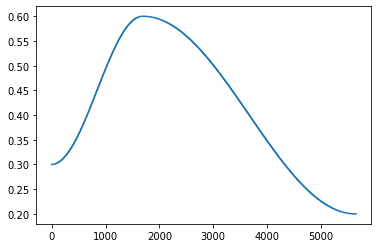

In [256]:
trainingSubscriber.plotLearningRate()

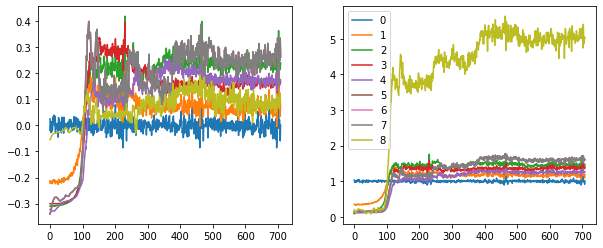

In [257]:
trainingSubscriber.plotMeansAndStandardDeviations()

## Todo: 


## Things to look at later

- Learning Rate Capping
- Bias Learning rate annealing
